# CompositionDE - Compositional analysis of single-cell data



This notebook serves as a tutorial for using the *CompositionDE* package to analyze changes in cell composition data.

The package is intended to be used with data coming from single-cell RNA-seq experiments, however there are no 
restrictions that prevent the use of data from other sources.

The data we use in the following example comes from [*Haber et al. [2017]*](https://www.nature.com/articles/nature24489).
It contains samples from the small intestinal epithelium of mice with different conditions.


In [1]:
# Setup

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import importlib
import arviz as az
import anndata as ad
import warnings

from SCDCpy.util import compositional_analysis_generation_toolbox as gen
from SCDCpy.util import comp_ana as mod
from SCDCpy.util import result_classes as res



warnings.filterwarnings("ignore")

C:\Users\Johannes\Anaconda3\envs\Helmholtz\lib\site-packages\anndata\_core\anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


### Data preparation

In [31]:
# Load data

cell_counts = pd.read_csv("C:\\Users\\Johannes\\Documents\\Uni\\Master's_Thesis\\compositionalDiff-johannes_tests_2\\data\\haber_counts.csv")

print(cell_counts)

            Mouse  Endocrine  Enterocyte  Enterocyte.Progenitor  Goblet  Stem  \
0       Control_1         36          59                    136      36   239   
1       Control_2          5          46                     23      20    50   
2       Control_3         45          98                    188     124   250   
3       Control_4         26         221                    198      36   131   
4  H.poly.Day10_1         42          71                    203     147   271   
5  H.poly.Day10_2         40          57                    383     170   321   
6   H.poly.Day3_1         52          75                    347      66   323   
7   H.poly.Day3_2         65         126                    115      33    65   
8          Salm_1         37         332                    113      59    90   
9          Salm_2         32         373                    116      67   117   

    TA  TA.Early  Tuft  
0  125       191    18  
1   11        40     5  
2  155       365    33  
3  130  

Looking at the data, we see that we have 4 control samples, and 3 conditions with 2 samples each. To use the models in *compositionDE*, we first have to convert the data into an *anndata* object. For this example, we only use the Salmonella infection.

In [32]:
# Convert data to anndata objects - one for each condition

# Cell counts
x = cell_counts.iloc[:, 1:].to_numpy()
print(x)

# Conditions - Set
obs = pd.DataFrame(cell_counts["Mouse"])
obs["Condition"] = obs["Mouse"].str.replace(r"_[0-9]", "")
print(obs)

# Cell type names
var = pd.DataFrame(index=cell_counts.iloc[:, 1:].columns)
print(var)

# Salmonella data
salm_indices = [0, 1, 2, 3, 8, 9]
data_salm = ad.AnnData(X=x[salm_indices, :], obs=obs.iloc[salm_indices, :], var=var)

Transforming to str index.


[[ 36  59 136  36 239 125 191  18]
 [  5  46  23  20  50  11  40   5]
 [ 45  98 188 124 250 155 365  33]
 [ 26 221 198  36 131 130 196   4]
 [ 42  71 203 147 271 109 180 146]
 [ 40  57 383 170 321 244 256  71]
 [ 52  75 347  66 323 263 313  51]
 [ 65 126 115  33  65  39 129  59]
 [ 37 332 113  59  90  47 132  10]
 [ 32 373 116  67 117  65 168  12]]
            Mouse     Condition
0       Control_1       Control
1       Control_2       Control
2       Control_3       Control
3       Control_4       Control
4  H.poly.Day10_1  H.poly.Day10
5  H.poly.Day10_2  H.poly.Day10
6   H.poly.Day3_1   H.poly.Day3
7   H.poly.Day3_2   H.poly.Day3
8          Salm_1          Salm
9          Salm_2          Salm
Empty DataFrame
Columns: []
Index: [Endocrine, Enterocyte, Enterocyte.Progenitor, Goblet, Stem, TA, TA.Early, Tuft]


### Model setup and inference

We can now create the model and run inference on it. A baseline index of *None* specifies the model without baseline specification, a specific baseline index is set by its numerical value

In [33]:
model_salm = mod.CompositionalAnalysis(data_salm, formula="Condition", baseline_index=None)

In [36]:
sim_results = model_salm.sample_hmc(num_results=20000, n_burnin=5000)
sim_results.summary()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
MCMC sampling finished. (118.832 sec)
Acceptance rate: 75.3%
get_y_hat (11.130 sec)
converted posterior (0.015 sec)
Compositional Analysis summary:
Intercepts:
                       Final Parameter  HPD 3%  HPD 97%     SD  \
Cell Type                                                        
Endocrine                        1.090   0.361    1.773  0.374   
Enterocyte                    

### Diagnostics and plotting

For further analysis, the results objetct supports all functions of arviz

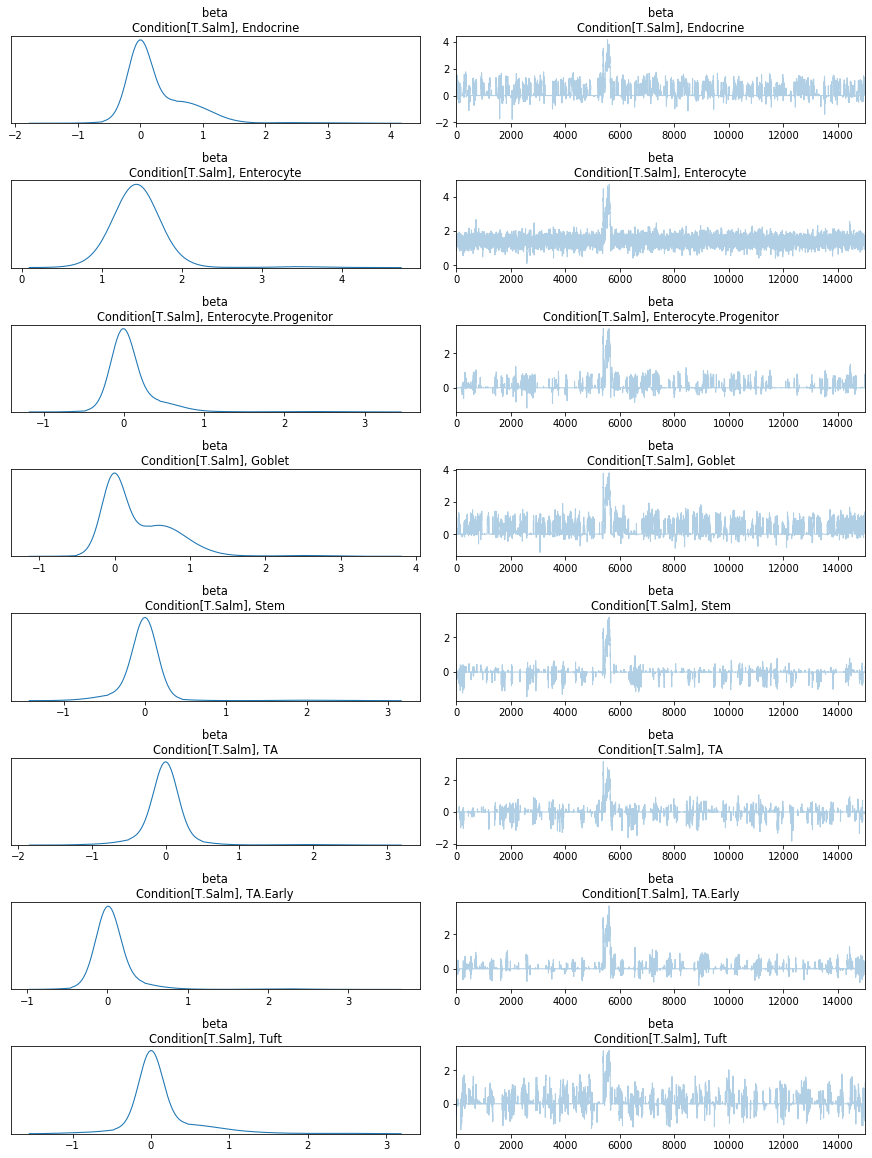

In [37]:
az.plot_trace(sim_results, var_names="beta")
plt.show()